<a href="https://colab.research.google.com/github/shinnew9/cse347-cse447RL/blob/main/lab3_TD_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Temporal Difference Learning

In this lab, we will practice TD Learning methods, including SARSA and Q-Learning. Both are tabular methods that work on finite MDP.

We will solve the cliff problem: https://gymnasium.farama.org/environments/toy_text/cliff_walking/#is_slippy


The following code runs in colab, if you want to see the animation, you have to run it using python locally on your computer and replacing render_mode="ansi" for render_mode="human".

Thef follwing code runs the cliff problem using a random policy.

In [ ]:
import gymnasium as gym

# Create the environment
env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 5      # number of episodes to run
max_steps = 100     # safety cap

for episode in range(n_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0

    for step in range(max_steps):
        # Random policy: sample an action uniformly
        action = env.action_space.sample()

        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    print(f"Episode {episode+1}: total reward = {total_reward}")

env.close()

Episode 1: total reward = -991
Episode 2: total reward = -1288
Episode 3: total reward = -61
Episode 4: total reward = -1189
Episode 5: total reward = -892


## Exercise 1: SARSA
Implement SARSA to solve the cliff problem above. Recommendations:



1. Define your Q table, as a matrix of [number of states] x [number of actions]
2. Greedy policy: Write a function that receives a state, the Q table, and returns the best action (the one with the maximum Q value).
3. $\epsilon$-greedy: Wreite a function that chooses the greedy policy with $\epsilon$ probality, and chooses a random actions with 1-$\epsilon$ probability.
4. Implement the SARSA algorithm based on the pseudo-code



In [ ]:
import gymnasium as gym
import numpy as np
# from collections import default

# Create the environment
env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 1000      # number of episodes to run
max_steps = 100     # safety cap

# Q-learning parameters
learning_rate = 0.1
discount_factor = 0.99
epsilon = 0.1 # Epsilon for epsilon-greedy policy
rng = np.random.default_rng() # Random number generator

n_actions = env.action_space.n
n_states = env.observation_space.n
Q = np.zeros((n_states, n_actions))


def greedy_action(Q, state):
    """Return argmax_a Q[state, a]."""
    return int(np.argmax(Q[state]))

def epsilon_greedy(Q, state, n_actions, epsilon, rng):
    """With prob ε: random action, else: greedy."""
    if rng.random() < epsilon:
        return int(rng.integers(0, n_actions))
    else:
        return greedy_action(Q, state)


## sarsa Training ##
def sarsa(env, Q, n_episodes, learning_rate, n_actions, n_states, epsilon, rng):
  rewards_list = []
  for episode in range(n_episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    A = epsilon_greedy(Q, state, n_actions, epsilon, rng)
    while not (terminated or truncated):
      next_state, reward, terminated, truncated, info = env.step(A)
      total_reward += reward
      next_A = epsilon_greedy(Q, next_state, n_actions, epsilon, rng)
      Q[state, A] = Q[state, A] + learning_rate * (reward + discount_factor * Q[next_state, next_A] - Q[state, A])
      state = next_state
      A = next_A
    rewards_list.append(total_reward)
    # print(f"Episode {episode+1}: total reward = {total_reward}")
    # print(f"Episode {episode%100}: total_reward = {total_reward%100}")
  return Q, rewards_list



if __name__ == "__main__":
  Q_sarsa, rewards_sarsa = sarsa(env, Q, n_episodes, learning_rate, n_actions, n_states, epsilon, rng)
  env.close()

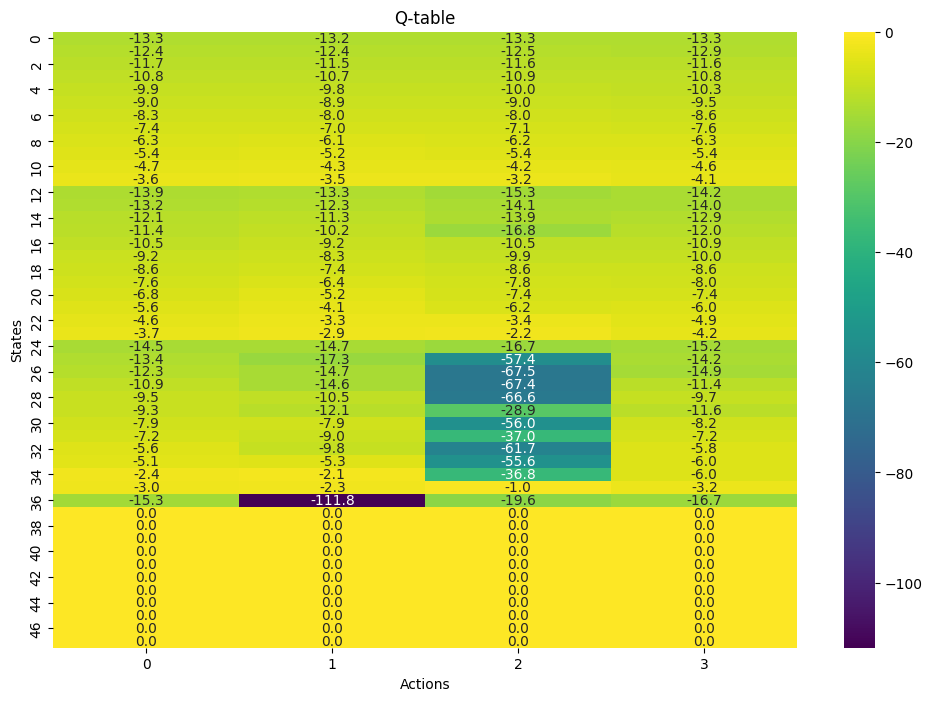

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_Q(Q):
  plt.figure(figsize=(12, 8))
  sns.heatmap(Q, annot=True, fmt=".1f", cmap="viridis")
  plt.xlabel("Actions")
  plt.ylabel("States")
  plt.title("Q-table")
  plt.show()

plot_Q(Q)

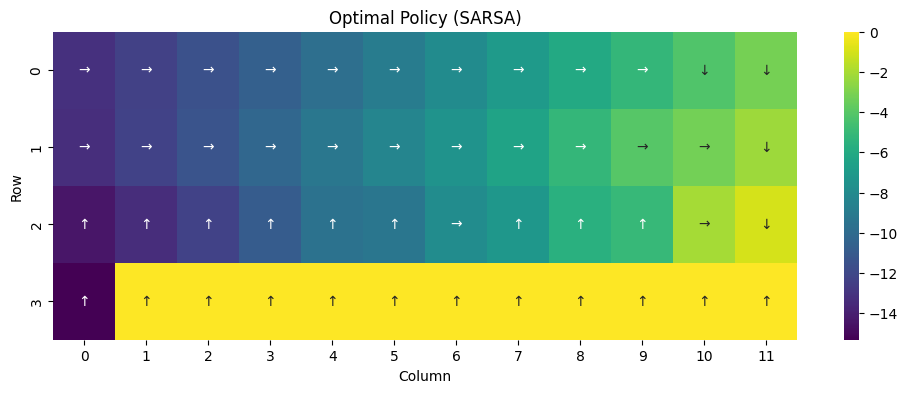

In [ ]:
def plot_policy(Q, title="SARSA"):
  # Reshape Q table to a 4x12 grid
  Q_grid = Q.reshape((4, 12, n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)


  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)


  plt.figure(figsize=(12, 4))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title("Optimal Policy (SARSA)")
  plt.show()
plot_policy(Q)

## Exercise 2.1: Q: Learning
Implement Q-learning method to solve the cliff problem

In [ ]:
import gymnasium as gym
import numpy as np
# from collections import default

# Create the environment
env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 3000      # number of episodes to run
max_steps = 100     # safety cap

# Q-learning parameters
learning_rate = 0.1
discount_factor = 0.99
epsilon = 0.11 # Epsilon for epsilon-greedy policy
# rng = np.random.default_rng() # Random number generator # Commenting out to re-initialize inside function

n_actions = env.action_space.n
n_states = env.observation_space.n
Q = np.zeros((n_states, n_actions))


def greedy_action(Q, state):
    """Return argmax_a Q[state, a]."""
    return int(np.argmax(Q[state]))

def epsilon_greedy(Q, state, n_actions, epsilon, rng):
    """With prob ε: random action, else: greedy."""
    if rng.random() < epsilon:
        return int(rng.integers(0, n_actions))
    else:
        return greedy_action(Q, state)


def qlearning(env, Q, n_episodes, learning_rate, n_actions, epsilon, rng=None, max_steps=100, discount_factor=0.99, epsilon_end=0.05, epsilon_decay=0.995, seed=42, options=None):
    """
    Tabular Q-learning for CliffWalking-v1.

    Args:
        env: Gymnasium env (already created)
        Q:   (n_states, n_actions) initial Q-table (will be modified)
        n_episodes: number of training episodes
        learning_rate: alpha
        n_actions: env.action_space.n
        epsilon: initial epsilon for epsilon-greedy
        rng: np.random.Generator or None/int (if None -> create inside)
        max_steps: safety cap per episode
        discount_factor: gamma
        epsilon_end/epsilon_decay: ε schedule
        seed: used only if rng is None

    Returns:
        Q: updated Q-table
        returns: np.array of episode returns
    """
    # RNG
    if rng is None or isinstance(rng, (int, np.integer)):
        rng = np.random.default_rng(seed)

    returns = []
    eps = float(epsilon)

    for ep in range(1, n_episodes + 1):
        state, info = env.reset(seed=int(rng.integers(0, 10_000)), options=options)
        total_reward = 0.0
        terminated = truncated = False

        for t in range(max_steps):
            # ε-greedy
            action = epsilon_greedy(Q, state, n_actions, eps, rng)

            # 환경 전이
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward

            # Q-learning target: r + γ * max_a' Q(s', a')  (terminal이면 미래가치 0)
            if done:
                td_target = reward
            else:
                td_target = reward + discount_factor * np.max(Q[next_state])

            # Q-learning update
            Q[state, action] += learning_rate * (td_target - Q[state, action])

            state = next_state
            if done:
                break

        returns.append(total_reward)

        # ε schedule
        eps = max(epsilon_end, eps * epsilon_decay)

        # 진행 로그 (선택)
        if ep % 100 == 0:
            avg100 = np.mean(returns[-100:])
            # print(f"[Q-learning] ep {ep}/{n_episodes}  ε={eps:.3f}  avg_return(last100)={avg100:.2f}")

    return Q, np.array(returns, dtype=np.float32)





if __name__ == "__main__":
  # Need to pass n_states to the qlearning function
  Q_q_learning, rewards_q_learning = qlearning(env, Q.copy(), n_episodes, learning_rate, n_actions, epsilon, rng, max_steps=max_steps)
  env.close()

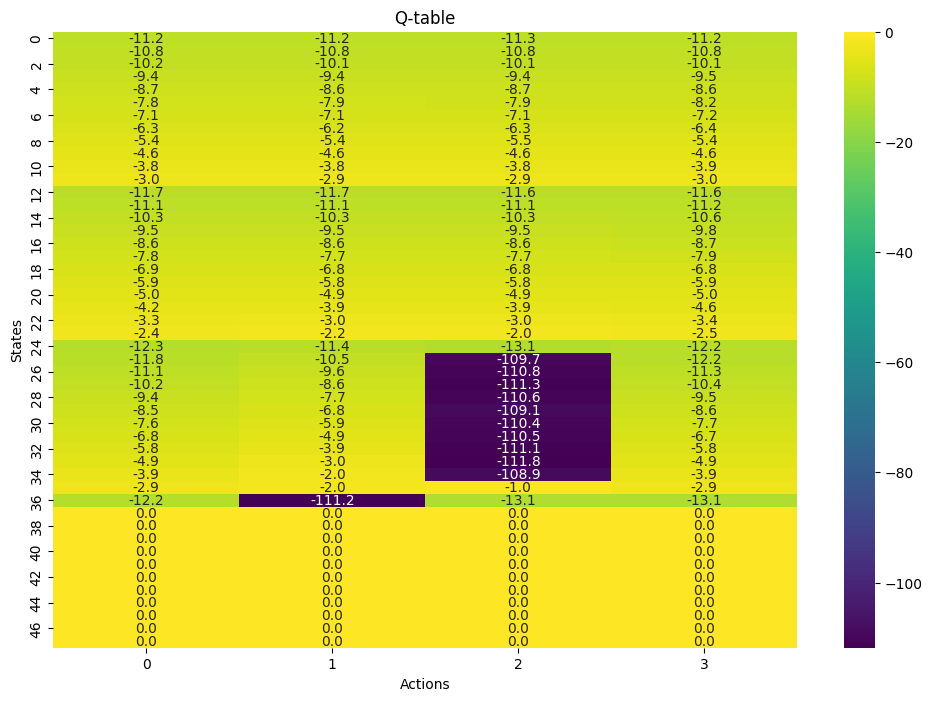

In [ ]:
# Updating
Q_q_learning, rewards_q_learning = qlearning(
    env, Q, n_episodes, learning_rate, n_actions,
    epsilon, rng, max_steps=max_steps, discount_factor=discount_factor
)

# Drawing the updated version
plot_Q(Q)

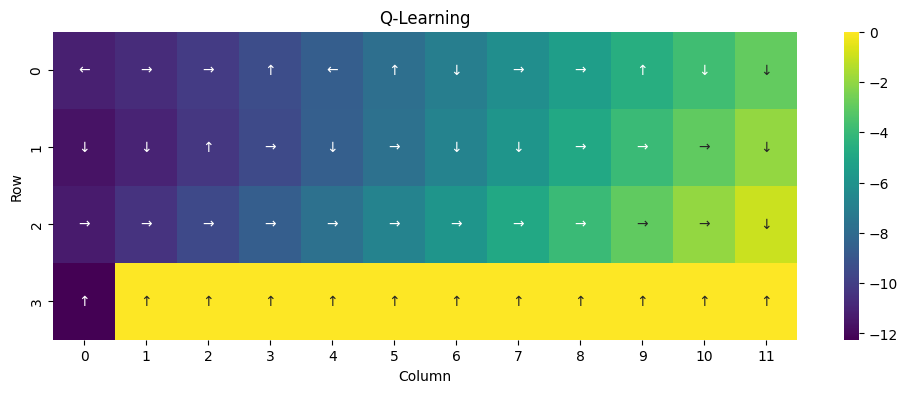

In [ ]:
def plot_policy(Q, title="Q-Learning"):
  # Reshape Q table to a 4x12 grid
  Q_grid = Q.reshape((4, 12, n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)


  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)


  plt.figure(figsize=(12, 4))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title("Q-Learning")
  plt.show()
plot_policy(Q)

## Exercise 2.2: SARSA vs Q-learning
 1. Compare the results betwen SARSA and Q-Learning (plot a graph of the sum of rewards duing each episode for each algorithm).
 2. Include the is_slippery=True parameter. Compare again, which one is better?


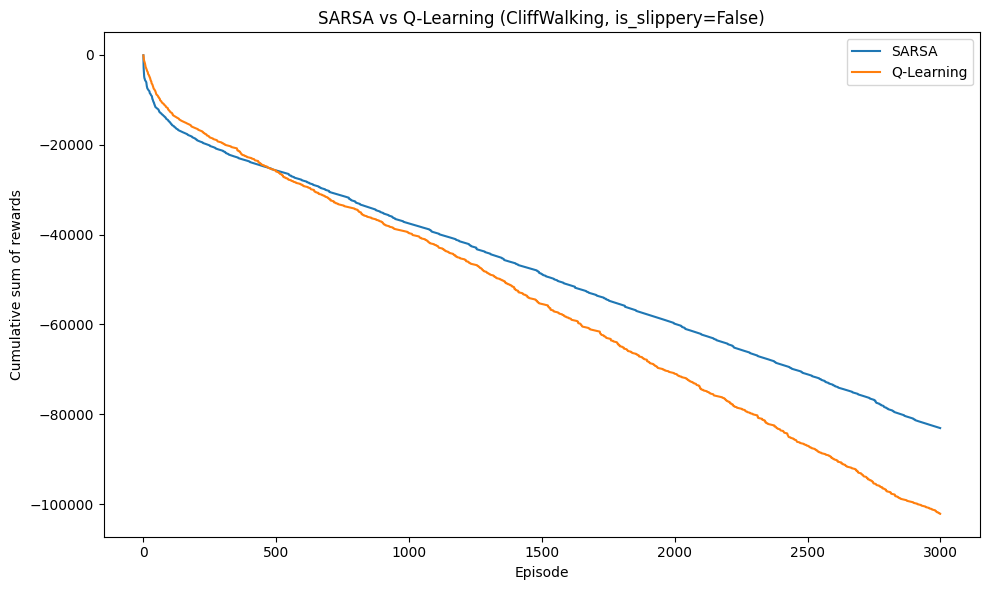

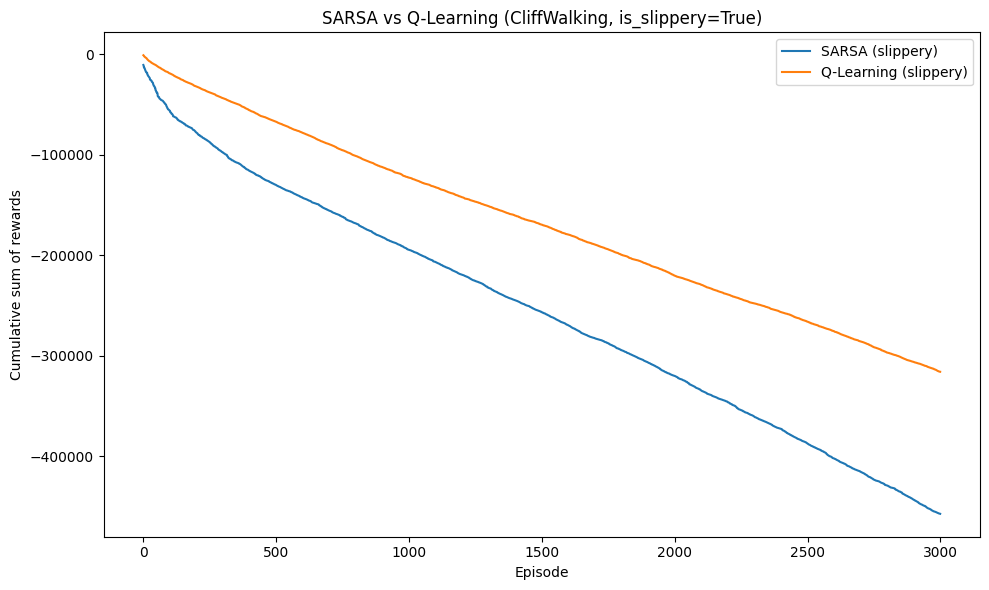

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# reusing
ENV_ID = "CliffWalking-v1"

def run_once(is_slippery=False, seed_s=0, seed_q=1):
    # 각각 별도의 env / rng 로 공정 비교
    env_s = gym.make(ENV_ID, render_mode="ansi", is_slippery=is_slippery)
    env_q = gym.make(ENV_ID, render_mode="ansi", is_slippery=is_slippery)

    rng_s = np.random.default_rng(seed_s)
    rng_q = np.random.default_rng(seed_q)

    Q0_s = np.zeros((n_states, n_actions))
    Q0_q = np.zeros((n_states, n_actions))

    # 네가 이미 만든 함수 그대로 호출 (시그니처 유지)
    Q_sarsa, rewards_sarsa = sarsa(
        env_s, Q0_s, n_episodes, learning_rate, n_actions, n_states, epsilon, rng_s
    )
    Q_qlearn, rewards_qlearn = qlearning(
        env_q, Q0_q, n_episodes, learning_rate, n_actions, epsilon, rng_q # Pass rng_q here
    )

    env_s.close(); env_q.close()
    return rewards_sarsa, rewards_qlearn

# 1) is_slippery=False
rewards_sarsa, rewards_qlearn = run_once(is_slippery=False)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(rewards_sarsa), label="SARSA")
plt.plot(np.cumsum(rewards_qlearn), label="Q-Learning")
plt.xlabel("Episode"); plt.ylabel("Cumulative sum of rewards")
plt.title("SARSA vs Q-Learning (CliffWalking, is_slippery=False)")
plt.legend(); plt.tight_layout(); plt.show()

# 2) is_slippery=True
rewards_sarsa_s, rewards_qlearn_s = run_once(is_slippery=True)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(rewards_sarsa_s), label="SARSA (slippery)")
plt.plot(np.cumsum(rewards_qlearn_s), label="Q-Learning (slippery)")
plt.xlabel("Episode"); plt.ylabel("Cumulative sum of rewards")
plt.title("SARSA vs Q-Learning (CliffWalking, is_slippery=True)")
plt.legend(); plt.tight_layout(); plt.show()

Deterministic: Q-learning usually wins by learning the shortest path, giving higher average returns.
Slippery: SARSA is safer; it avoids the cliff and yields steadier (often less negative) returns.

# Exercise 3 (graduate students): 8x8 grid problem
Solve the 8x8 grid problem from the previous lab. You can use SARSA or Q-learning. How many episodes does it need to learn the optimal policy?


In [ ]:
!pip install gymnasium gym-simplegrid numpy matplotlib

In [ ]:
# === 8x8 Grid (SimpleGrid-8x8-v0) — Q-learning with options + curves ===
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_simplegrid
import os

# ---------- ENV CONFIG ----------
ENV_ID = "SimpleGrid-8x8-v0"
START_LOC, GOAL_LOC = 15, 3
OPTIONS = {"start_loc": START_LOC, "goal_loc": GOAL_LOC}
GRID_N = 8

# ---------- HYPERPARAMS ----------
alpha = 0.5
gamma = 0.99
eps_start, eps_end, eps_decay = 1.0, 0.05, 0.995
max_steps = 200
episodes = 10_000
seed = 42

# ---------- HELPERS ----------
def epsilon_greedy(Q, s, eps, nA, rng):
    """NOTE: order = (Q, state, eps, nA, rng)"""
    if rng.random() < eps:
        return int(rng.integers(0, nA))
    return int(np.argmax(Q[s]))

def idx2rc(idx, n=GRID_N):
    return divmod(idx, n)

def manhattan(a, b, n=GRID_N):
    ra, ca = idx2rc(a, n); rb, cb = idx2rc(b, n)
    return abs(ra - rb) + abs(ca - cb)

def moving_avg(x, w=50):
    x = np.asarray(x, dtype=float)
    if len(x) < w: return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

# ---------- Q-LEARNING (with options=OPTIONS) ----------
def qlearning(env, Q, n_episodes, learning_rate, n_actions, epsilon,
              rng=None, max_steps=100, discount_factor=0.99,
              epsilon_end=0.05, epsilon_decay=0.995, seed=42, options=None):
    """
    Tabular Q-learning for gym_simplegrid SimpleGrid-8x8-v0.
    Returns: (Q, returns_per_episode)
    """
    if rng is None or isinstance(rng, (int, np.integer)):
        rng = np.random.default_rng(seed)

    eps = float(epsilon)
    returns = []

    for ep in range(1, n_episodes + 1):
        state, info = env.reset(seed=int(rng.integers(0, 10_000)), options=options)
        terminated = truncated = False
        total = 0.0

        for t in range(max_steps):
            # ✅ FIXED ORDER: (Q, state, eps, n_actions, rng)
            action = epsilon_greedy(Q, state, eps, n_actions, rng)

            # step
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total += reward

            # Q-learning target
            target = reward if done else reward + discount_factor * np.max(Q[next_state])
            Q[state, action] += learning_rate * (target - Q[state, action])

            state = next_state
            if done:
                break

        returns.append(total)
        eps = max(epsilon_end, eps * epsilon_decay)

        if ep % 500 == 0:
            print(f"[Q] ep {ep}/{n_episodes}  ε={eps:.3f}  avg100={np.mean(returns[-100:]):.2f}")

    return Q, np.array(returns, dtype=np.float32)

# ---------- EVALUATE (greedy) & LOG for plotting ----------
def evaluate_greedy_log(env_id, Q, episodes=2000, options=None, max_steps=200, seed=123):
    env = gym.make(env_id)  # no render, fast
    rng = np.random.default_rng(seed)
    steps_hist, success_hist = [], []

    for ep in range(episodes):
        s, info = env.reset(seed=int(rng.integers(0, 10_000)), options=options)
        done, steps = False, 0
        while not done and steps < max_steps:
            a = int(np.argmax(Q[s]))  # greedy w.r.t. learned Q
            ns, r, terminated, truncated, info = env.step(a)
            s, steps, done = ns, steps + 1, (terminated or truncated)
        steps_hist.append(steps)
        success_hist.append(int(s == GOAL_LOC))

    env.close()
    return np.array(steps_hist), np.array(success_hist)

def detect_convergence(steps_hist, success_hist, window=50):
    """
    Converged if: success rate == 1.0 and avg steps == Manhattan shortest
    over the last 'window' episodes. Returns first episode index (1-based) or None.
    """
    optimal = manhattan(START_LOC, GOAL_LOC, n=GRID_N)
    for k in range(window, len(steps_hist) + 1):
        sr = np.mean(success_hist[k - window:k])
        avg_steps = np.mean(steps_hist[k - window:k])
        if sr == 1.0 and int(round(avg_steps)) == optimal:
            return k, optimal
    return None, optimal

# ---------- PLOT ----------
def plot_grid8_curves(steps_hist, success_hist, optimal, first_meet, window=50, title="Q-learning on 8x8"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Steps per episode (with moving average)
    ax[0].plot(steps_hist, alpha=0.35, label="steps/ep")
    ma_steps = moving_avg(steps_hist, window)
    if len(ma_steps) > 0:
        ax[0].plot(range(window - 1, window - 1 + len(ma_steps)), ma_steps, lw=2, label=f"MA(w={window})")
    ax[0].axhline(optimal, ls="--", color="k", label=f"optimal steps = {optimal}")
    if first_meet is not None:
        ax[0].axvline(first_meet, ls="--", color="tab:green", label=f"first meet @ {first_meet}")
    ax[0].set_title(title + " — Steps")
    ax[0].set_xlabel("Episode"); ax[0].set_ylabel("Steps")
    ax[0].legend()

    # Success rate (moving average)
    ma_succ = moving_avg(success_hist, window)
    ax[1].plot(success_hist, alpha=0.2, label="success (0/1)")
    if len(ma_succ) > 0:
        ax[1].plot(range(window - 1, window - 1 + len(ma_succ)), ma_succ, lw=2, label=f"MA(w={window})")
    if first_meet is not None:
        ax[1].axvline(first_meet, ls="--", color="tab:green", label=f"first meet @ {first_meet}")
    ax[1].set_ylim(-0.05, 1.05)
    ax[1].set_title(title + " — Success rate")
    ax[1].set_xlabel("Episode"); ax[1].set_ylabel("Success")
    ax[1].legend()

    plt.tight_layout()
    out = os.path.abspath("grid8_q_learning_curves.png")
    plt.savefig(out, dpi=160)
    print(f"[plot] saved: {out}")
    plt.show()

# ---------- MAIN ----------
if __name__ == "__main__":
    # 1) Make env (for shapes)
    env_train = gym.make(ENV_ID)
    nS, nA = env_train.observation_space.n, env_train.action_space.n
    assert nA > 0, "Action space size must be > 0"

    # 2) Train Q-learning with OPTIONS
    Q0 = np.zeros((nS, nA), dtype=np.float32)
    rng = np.random.default_rng(seed)
    Q_star, returns = qlearning(
        env_train, Q0, episodes, alpha, nA, eps_start,
        rng=rng, max_steps=max_steps, discount_factor=gamma,
        epsilon_end=eps_end, epsilon_decay=eps_decay, seed=seed,
        options=OPTIONS   # <<< pass start/goal
    )
    env_train.close()

    print("Trained. Non-zero Q entries:", np.count_nonzero(Q_star))

    # 3) Log greedy performance for plotting
    steps_hist, success_hist = evaluate_greedy_log(
        ENV_ID, Q_star, episodes=2000, options=OPTIONS, max_steps=max_steps
    )

    # 4) Detect convergence & plot
    first_meet, optimal_steps = detect_convergence(steps_hist, success_hist, window=50)
    print("Optimal (Manhattan) steps:", optimal_steps)
    print("Episodes needed to learn the optimal policy:", first_meet)

    plot_grid8_curves(steps_hist, success_hist, optimal_steps, first_meet, window=50, title="Q-learning on 8x8")


[Q] ep 500/10000  ε=0.082  avg100=0.87
[Q] ep 1000/10000  ε=0.050  avg100=0.93
[Q] ep 1500/10000  ε=0.050  avg100=0.94
[Q] ep 2000/10000  ε=0.050  avg100=0.92
[Q] ep 2500/10000  ε=0.050  avg100=0.95
[Q] ep 3000/10000  ε=0.050  avg100=0.93
[Q] ep 3500/10000  ε=0.050  avg100=0.94
[Q] ep 4000/10000  ε=0.050  avg100=0.95
[Q] ep 4500/10000  ε=0.050  avg100=0.92
[Q] ep 5000/10000  ε=0.050  avg100=0.91
[Q] ep 5500/10000  ε=0.050  avg100=0.87
[Q] ep 6000/10000  ε=0.050  avg100=0.91
[Q] ep 6500/10000  ε=0.050  avg100=0.97
[Q] ep 7000/10000  ε=0.050  avg100=0.93
[Q] ep 7500/10000  ε=0.050  avg100=0.94
[Q] ep 8000/10000  ε=0.050  avg100=0.92
[Q] ep 8500/10000  ε=0.050  avg100=0.87
[Q] ep 9000/10000  ε=0.050  avg100=0.91
[Q] ep 9500/10000  ε=0.050  avg100=0.91
[Q] ep 10000/10000  ε=0.050  avg100=0.97


SystemExit: 

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
